# Table of Contents
## Version 1: Feedback dendrites have unlimited span+sparse connections
## Version 2: Feedback dendrites prefer nearest neighbor+sparse connections
## Version 3: Unlimited span+Fully connected

In [167]:
%reset
from bindsnet.network import Network
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.nodes import Input
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
import torch
import matplotlib.pyplot as plt
from torch import bernoulli, ones, randn
from time import time
from tqdm import tqdm

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from torchvision import transforms
import os

from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
#!echo "./data/MNIST" >> ./.gitignore ### run once only

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [233]:
total_timesteps = 500
dt = 1
num_epochs = 1
progress_interval = 10
update_interval = 250

intensity = 128

image_shape = (32, 32)
n_sensory_neurons = 32*32
dendrite_field_shape = image_shape
num_dendrite_layers = 1
input_neuron_weight = 5

seed = 8
batch_size = 1


torch.manual_seed(seed)

network = Network(dt=dt, learning=True, batch_size=1, reward_fn=None)

### In this setup, the physical weights between neurons don't change in the short term, only the dendritic feedback stimulation. Hence we first connect the network randomly.

# Version 1: Feedback dendrites have unlimited span but make relatively sparse connections

In [234]:
connection_prob = 0.3 #probability of any given feedback neuron
                      #connecting to any given sensory neuron
image_dim = image_shape[0]*image_shape[1]


input_layer = Input(n=image_dim, traces=True)
network.add_layer(input_layer, 'simulated input')

sensory_layer = LIFNodes(n=n_sensory_neurons, traces=True)
network.add_layer(sensory_layer, 'light-receptive neurons')

stim_layer = Input(n=image_dim, traces=True)
network.add_layer(stim_layer, 'brain self-stim')

dendrite_layers_container = []

for iii in range(num_dendrite_layers):
    dendrite_layers_container.append(LIFNodes(n=image_dim, traces=True))
    network.add_layer(dendrite_layers_container[iii], f"feedback {iii}")

In [292]:
input_sensory_connection = Connection(
                source=input_layer,
                target=sensory_layer,
                w = input_neuron_weight*torch.eye(input_layer.n, sensory_layer.n))

network.add_connection(input_sensory_connection,
                       source='simulated input',
                       target='light-receptive neurons')

dfs_dim = dendrite_field_shape[0]*dendrite_field_shape[1]
dendrite_sensory_connections_container = []
stim_dendrite_connections_container = []

for iii in range(num_dendrite_layers):

    weights = 0.01*bernoulli(0.1*torch.ones(dfs_dim, image_dim)+0.9*torch.eye(dfs_dim, image_dim))*torch.randn(dfs_dim, image_dim)
    
    dendrite_sensory_connections_container.append(Connection(
                            source=dendrite_layers_container[iii],
                            target=sensory_layer,
                            w = weights ))
    
    stim_dendrite_connections_container.append(Connection(
                            source=stim_layer,
                            target=dendrite_layers_container[iii],
                            w = input_neuron_weight*torch.eye(stim_layer.n, dendrite_layers_container[iii].n)))
    
    network.add_connection(dendrite_sensory_connections_container[iii],
                           source=f"feedback {iii}",
                           target='light-receptive neurons')
    network.add_connection(stim_dendrite_connections_container[iii],
                           source= 'brain self-stim',
                           target= f"feedback {iii}")
network

Network(
  (simulated input): Input()
  (light-receptive neurons): LIFNodes()
  (brain self-stim): Input()
  (feedback 0): LIFNodes()
  (simulated input_to_light-receptive neurons): Connection(
    (source): Input()
    (target): LIFNodes()
  )
  (feedback 0_to_light-receptive neurons): Connection(
    (source): LIFNodes()
    (target): LIFNodes()
  )
  (brain self-stim_to_feedback 0): Connection(
    (source): Input()
    (target): LIFNodes()
  )
)

In [293]:
network.connections[('feedback 0','light-receptive neurons')].w

Parameter containing:
tensor([[-5.0365e-04, -7.7267e-03, -0.0000e+00,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  2.2299e-03, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-0.0000e+00, -2.2250e-03,  7.5999e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ..., -5.9941e-03,
         -0.0000e+00, -0.0000e+00],
        [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
         -7.8365e-05,  0.0000e+00],
        [-0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.3222e-04]])

### Visualizing data with no feedback convolution

In [294]:
train_dataset = MNIST(PoissonEncoder(time=total_timesteps, dt=dt),
                      None,
                      root = os.path.join(".", "data", "MNIST"),
                      download=True,
                      train=True,
                      transform = transforms.Compose(
                                  [transforms.Resize((32, 32)),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x*intensity)])
                     )

In [295]:
spikes = { }
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer],
                           state_vars = ["s"],
                           time = total_timesteps)
    network.add_monitor(spikes[layer], name = f"{layer} spikes")

voltages = { }
for layer in set(network.layers)-{"simulated input",'brain self-stim'}:
    voltages[layer] = Monitor(network.layers[layer],
                              state_vars = ["v"],
                              time=total_timesteps)
    network.add_monitor(voltages[layer], name = f"{layer} voltages")

In [296]:
start = time()
training_pairs=[]

train_dataloader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True,)

def forward(datum, stim):
    
    datum = next(iter(train_dataloader))

    image = datum["encoded_image"]
    label = datum["label"]

    inputs = {"simulated input": image.view(total_timesteps, 1, image_dim),
             "brain self-stim": stim}

    network.run(inputs, time=total_timesteps)

    spikes_ = {layer: spikes[layer].get("s") for layer in spikes}
    voltages_ = {layer: voltages[layer].get("v") for layer in voltages}


    plt.ioff()
    plot_voltages(voltages_, plot_type="line")
    plot_spikes(spikes_)
    raw_im = datum["image"].view(32, 32)
    inpt = spikes_["light-receptive neurons"].view(total_timesteps, 32*32).sum(0).view(32, 32)
    plot_input(raw_im, inpt, label=label)


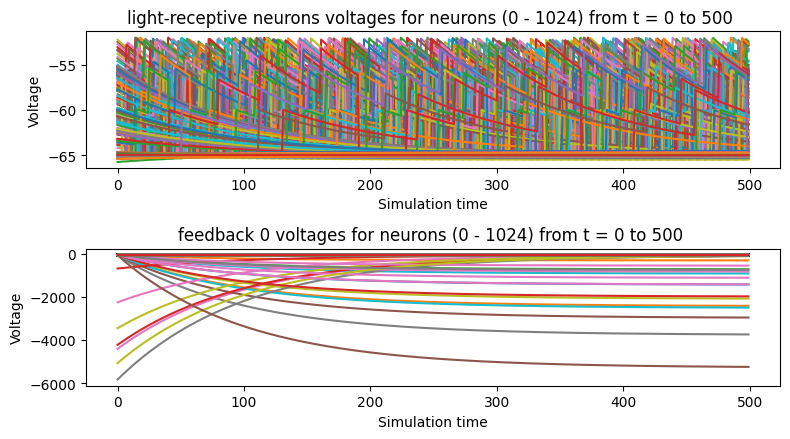

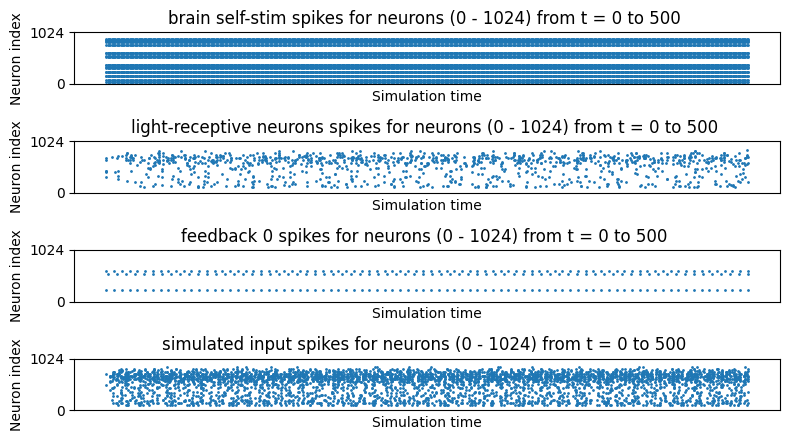

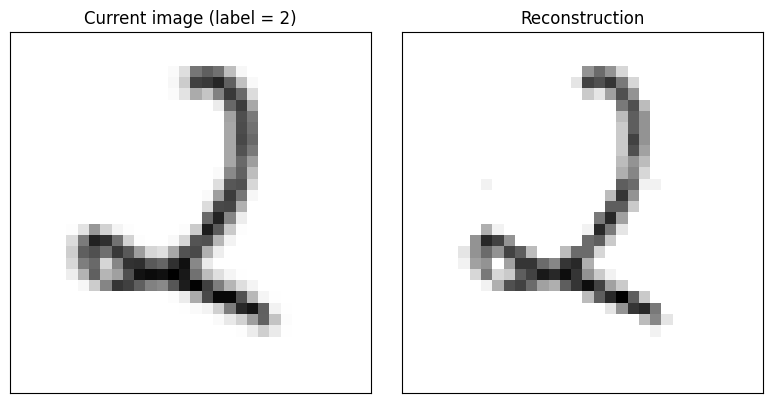

In [312]:
test = bernoulli(0.01*torch.ones(1, 1024))*torch.randn(1, 1024)*input_neuron_weight
test = test.expand((500, 1, 1024))
    
forward(next(iter(train_dataloader)), test)
plt.show()

In [313]:
torch.count_nonzero(test)

tensor(9500)

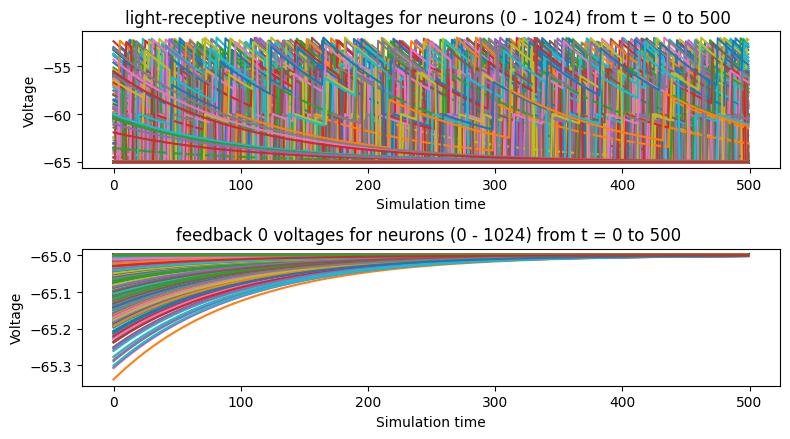

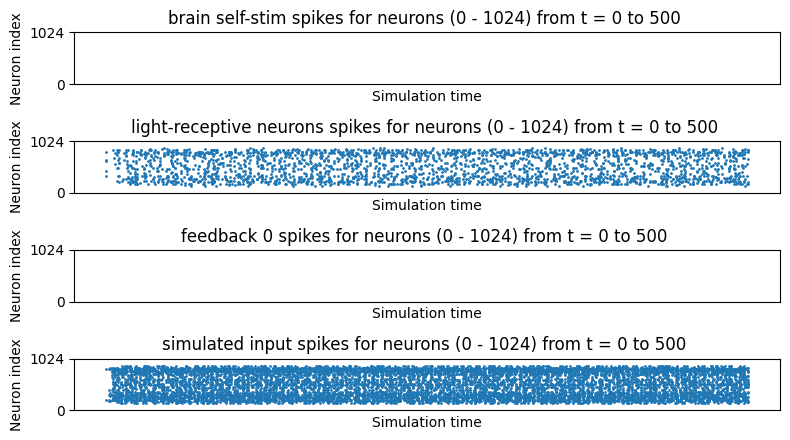

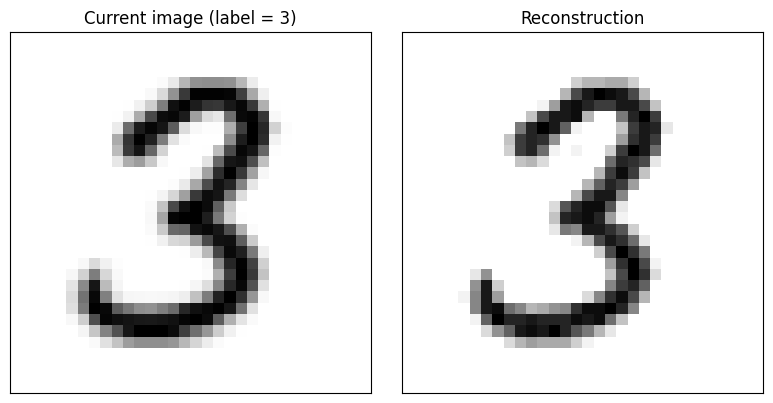

In [301]:
test2 = torch.zeros((total_timesteps, 1, image_dim)).byte()

forward(next(iter(train_dataloader)), test2)
plt.show()

# Version 2: Feedback dendrites prefer nearest neighbor, relatively sparse connections

# Version 3: Feedback dendrites have unlimited span and connect to all